#  Machine Learning project (2021-2022)

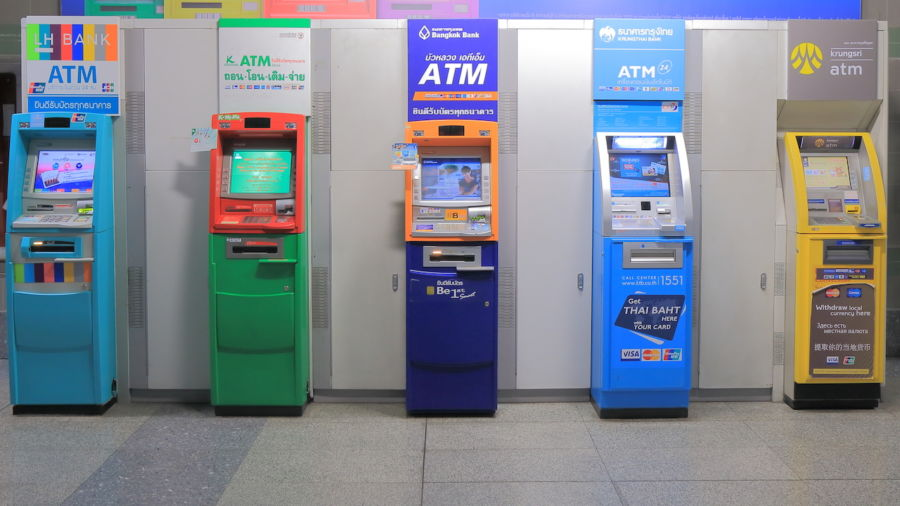

## About the Data

There are 25 variables:  
ID: ID of each client <br />
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary = credit) <br />
SEX: Gender (1=male, 2=female) <br />
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) <br />
MARRIAGE: Marital status (1=married, 2=single, 3=others) <br />
AGE: Age in years <br />
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above) <br />
PAY_2: Repayment status in August, 2005 (scale same as above) <br /> 
PAY_3: Repayment status in July, 2005 (scale same as above)<br />
PAY_4: Repayment status in June, 2005 (scale same as above)<br />
PAY_5: Repayment status in May, 2005 (scale same as above)<br />
PAY_6: Repayment status in April, 2005 (scale same as above)<br />
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)<br />
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)<br />
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)<br />
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)<br />
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)<br />
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)<br />
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)<br />
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)<br />
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)<br />
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)<br />
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)<br />
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)<br />
default.payment.next.month: Default payment (1=yes, 0=no) <br />

## Loading dependencies

In [61]:
#!pip install catboost
#!pip install xgboost

In [62]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import svm
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import time


## Loading data

In [63]:
#display the 5 first rows
df=pd.read_excel('default of credit card clients.xls',index_col=0,skiprows=1)
df['MARRIAGE']=np.where(df['MARRIAGE'] == 0, 3, df['MARRIAGE'])
df['EDUCATION']=np.where(df['EDUCATION'] == 5, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 6, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 0, 4, df['EDUCATION'])
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Understand the Data

In [5]:
#get information about the data (how many non null value , the type of each column)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [6]:
#All of our data is of type integer => using describle to extract some number proprities 
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


LIMIT_BAL


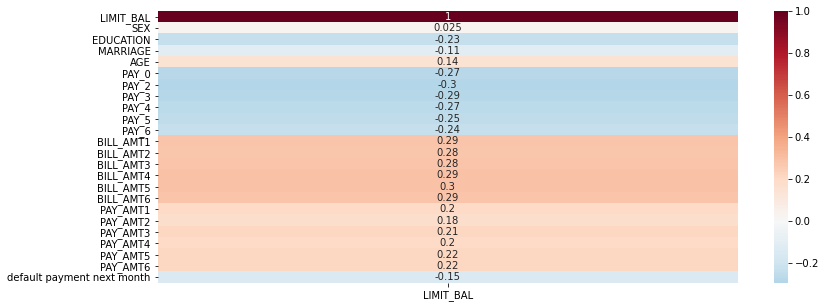

SEX


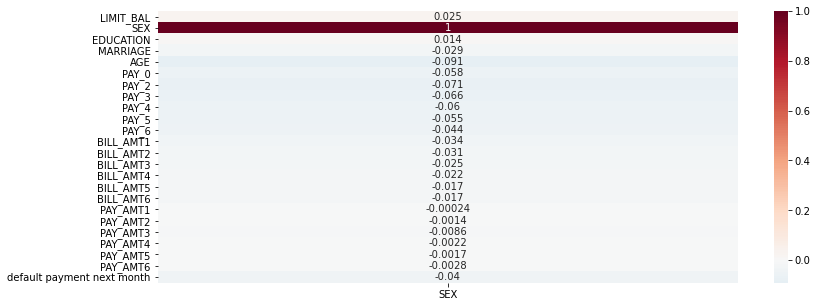

EDUCATION


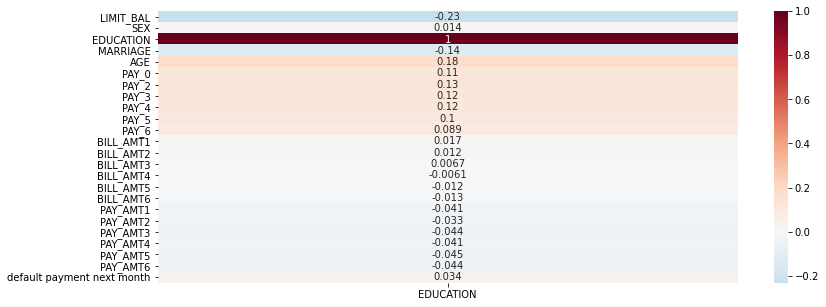

MARRIAGE


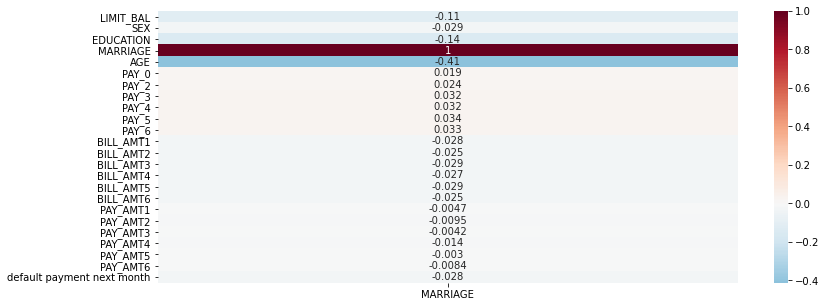

AGE


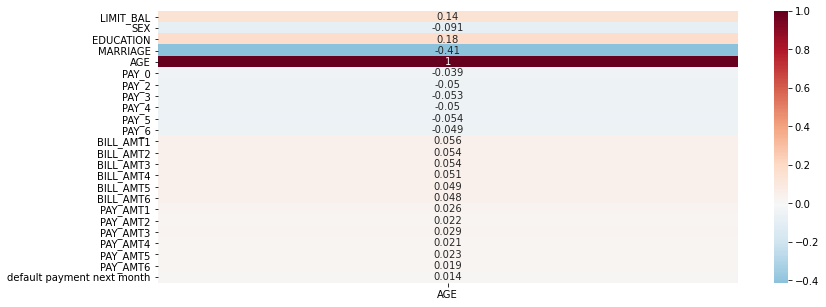

PAY_0


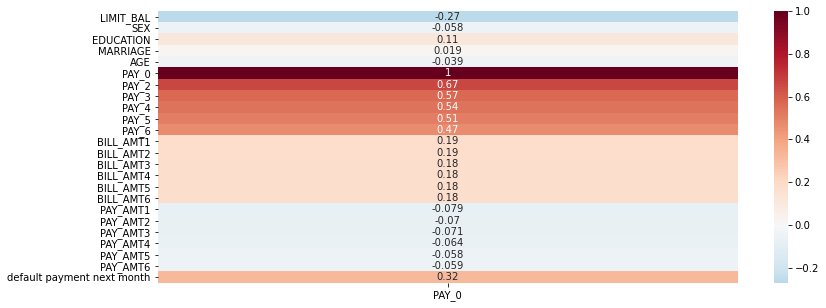

PAY_2


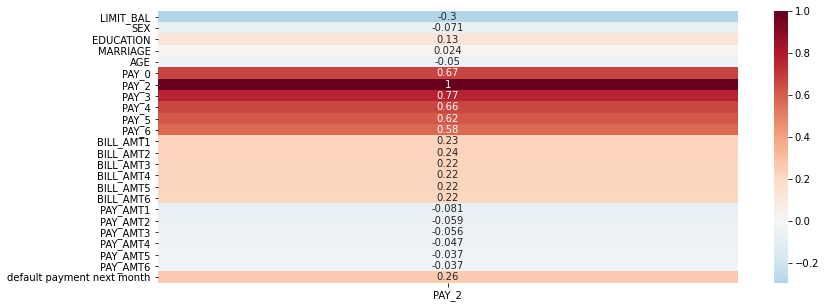

PAY_3


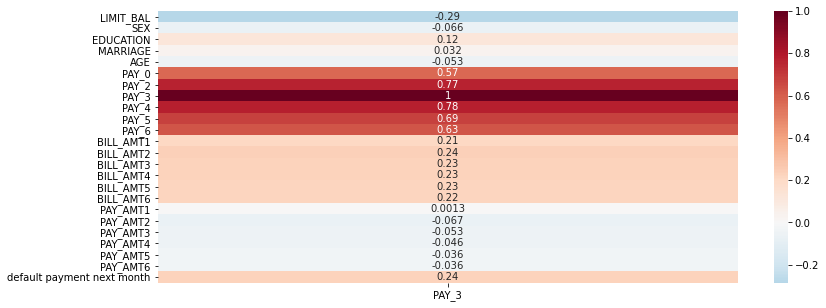

PAY_4


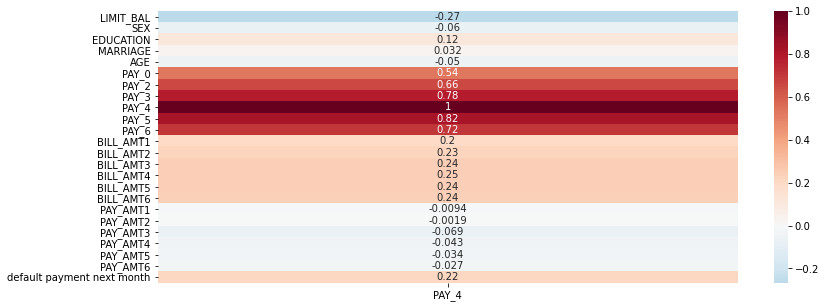

PAY_5


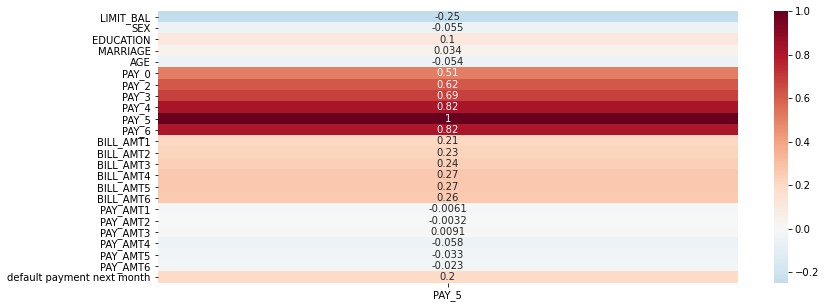

PAY_6


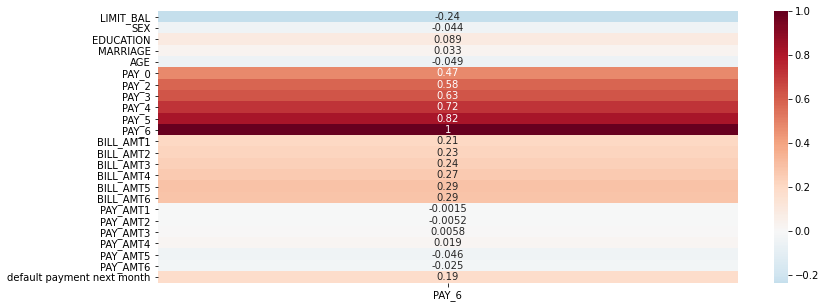

BILL_AMT1


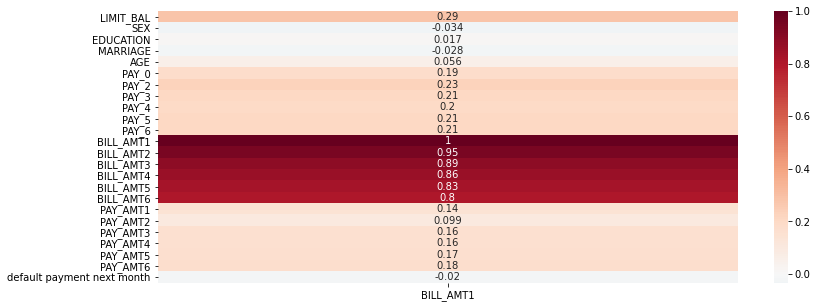

BILL_AMT2


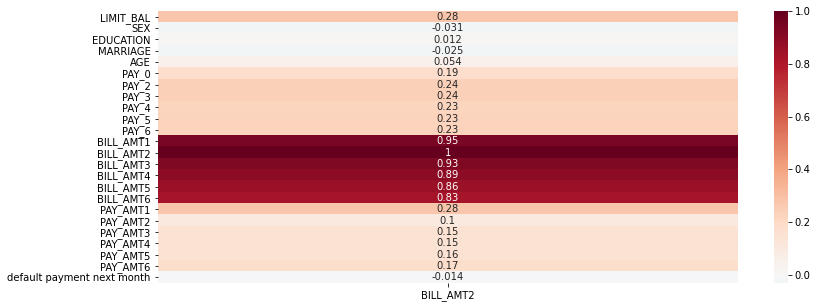

BILL_AMT3


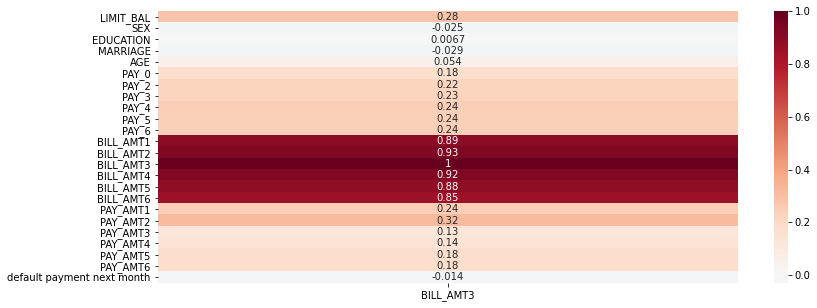

BILL_AMT4


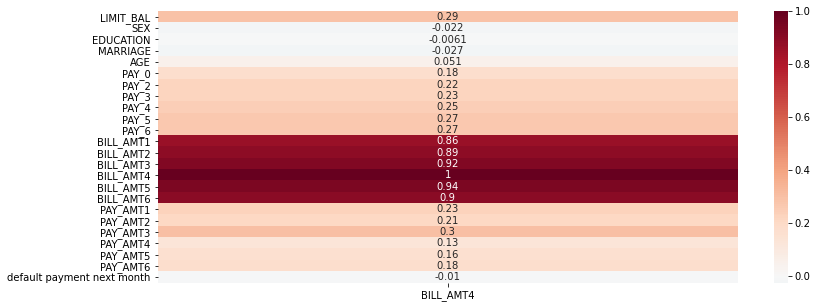

BILL_AMT5


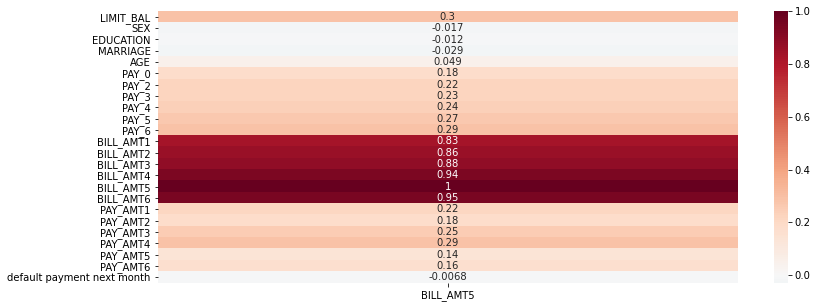

BILL_AMT6


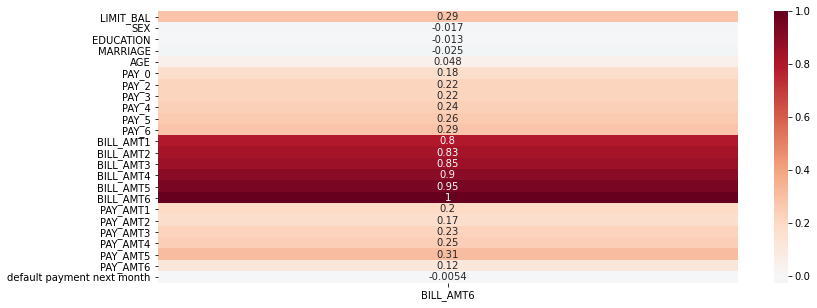

PAY_AMT1


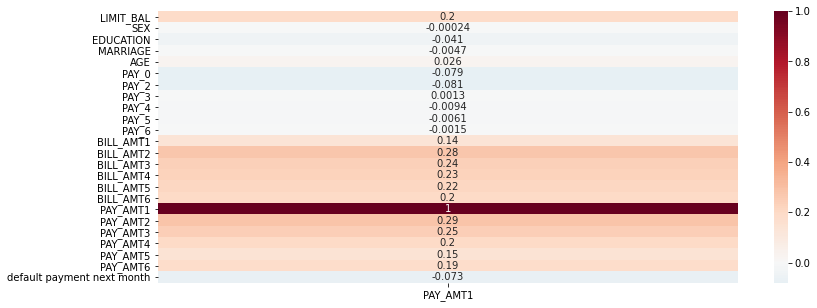

PAY_AMT2


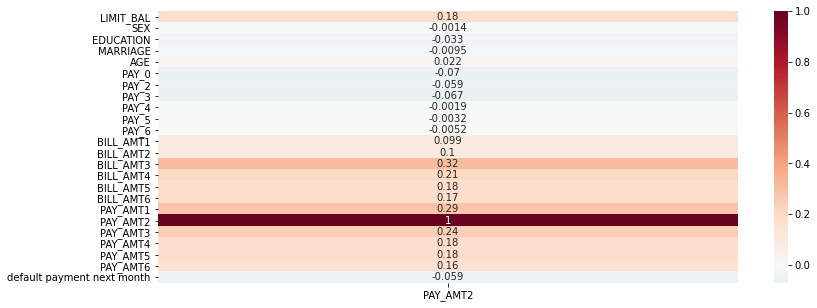

PAY_AMT3


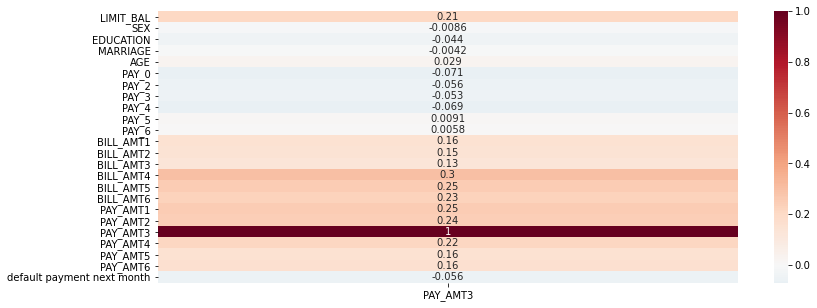

PAY_AMT4


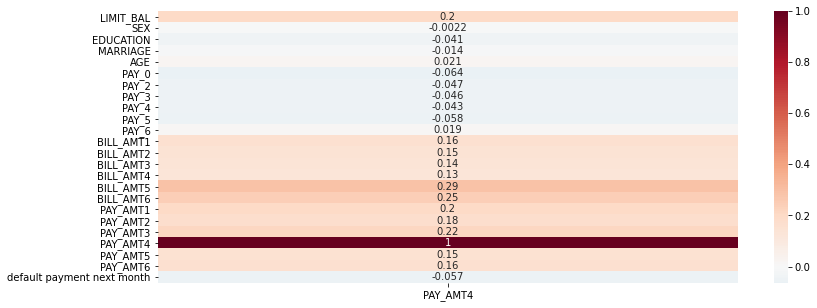

PAY_AMT5


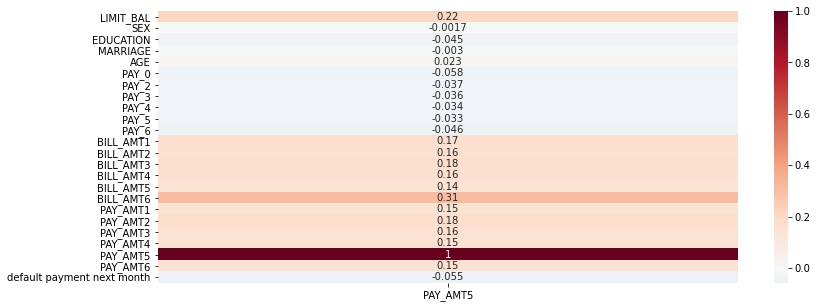

PAY_AMT6


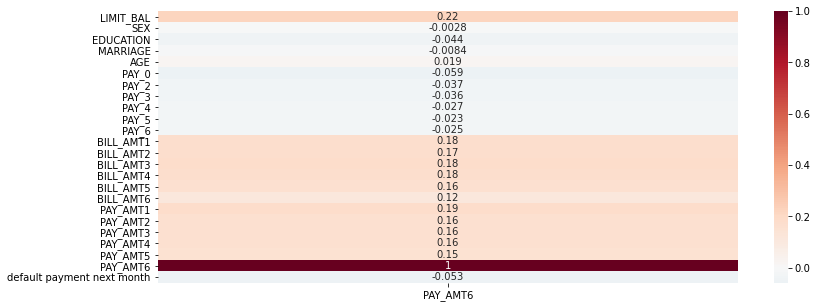

default payment next month


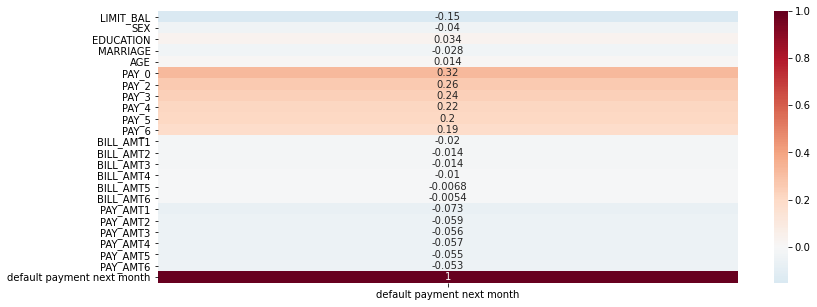

In [7]:
for i in range(len(df.columns)):
    print(df.columns[i])
    plt.figure(figsize=(13,5))
    sns.heatmap(df.corr()[[df.columns[i]]],cmap="RdBu_r",center=0.0, annot=True)
    plt.show()

In [8]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [9]:
# to know how many rows and columns we have
df.shape

(30000, 24)

## DEFAULT

In [10]:
df.rename(columns = {'PAY_0':'PAY_1', 'default payment next month':'Default'}, inplace = True)

In [11]:
df.Default.value_counts()

0    23364
1     6636
Name: Default, dtype: int64

 <br />The research paper mentionned that we have **25000** line of data and we have **30000** => therefore 16.66% of our data is dirty <br />
• **1106** line of data with the value 1 is dirty <br />
• **3894** line of data with the value 0 is dirty <br />  Data is unbalanced




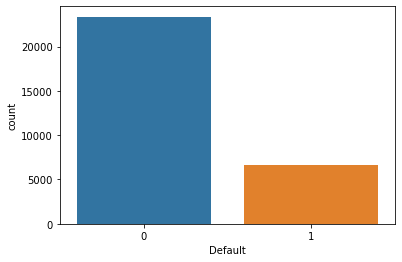

In [12]:
sns.countplot(x='Default', data=df)
plt.show()

## AGE

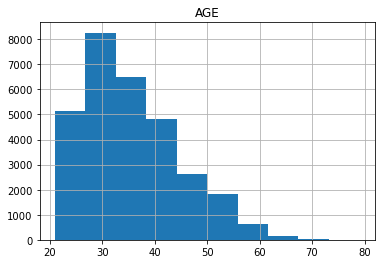

In [13]:
df.hist(column='AGE');

Clients within the age barcket of [20..40] are a majority


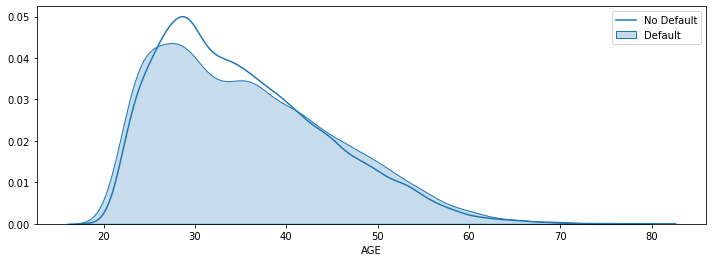

In [14]:
plt.figure(figsize=(12,4))

sns.kdeplot(df.loc[(df['Default'] == 0), 'AGE'], label = 'No Default', shade = False)
sns.kdeplot(df.loc[(df['Default'] == 1), 'AGE'], label = 'Default', shade = True )
plt.ylabel('')
plt.legend()
plt.show()

The space bitween No default and Default curves indicates that customers that are in the age barcket of [25..40] are more likely to have no default payment next month

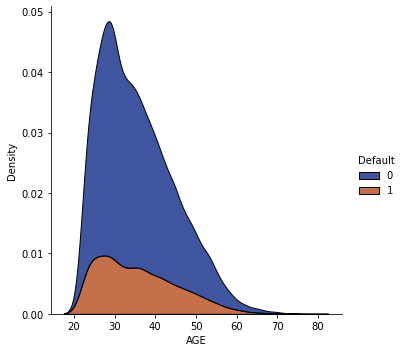

In [15]:
sns.displot(df, x="AGE", hue="Default", kind="kde", multiple="stack", palette = 'dark')


In [16]:
df['AgeBin'] = pd.cut(df['AGE'],[20, 25, 30, 35, 40, 50, 60, 80])
print(df['AgeBin'].value_counts())

(25, 30]    7142
(40, 50]    6005
(30, 35]    5796
(35, 40]    4917
(20, 25]    3871
(50, 60]    1997
(60, 80]     272
Name: AgeBin, dtype: int64


In [17]:
df['Default'].groupby(df['AgeBin']).value_counts(normalize = True)


AgeBin    Default
(20, 25]  0          0.733402
          1          0.266598
(25, 30]  0          0.798516
          1          0.201484
(30, 35]  0          0.805728
          1          0.194272
(35, 40]  0          0.783811
          1          0.216189
(40, 50]  0          0.767027
          1          0.232973
(50, 60]  0          0.747621
          1          0.252379
(60, 80]  0          0.731618
          1          0.268382
Name: Default, dtype: float64

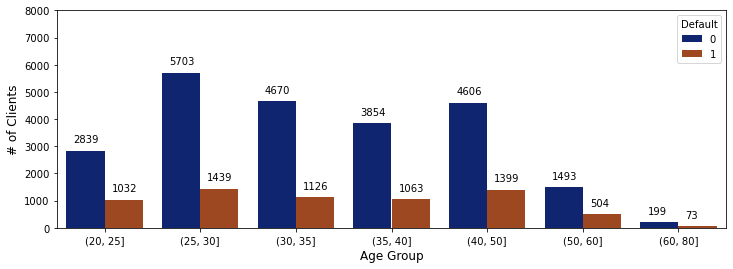

In [18]:
plt.figure(figsize=(12,4))

df['AgeBin'] = df['AgeBin'].astype('str')
AgeBin_order = ['(20, 25]', '(25, 30]', '(30, 35]', '(35, 40]', '(40, 50]', '(50, 60]', '(60, 80]']

ax = sns.countplot(data = df, x = 'AgeBin', hue="Default", palette = 'dark', order = AgeBin_order)

plt.xlabel("Age Group", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,8000)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.075, p.get_height()+300))

plt.show()

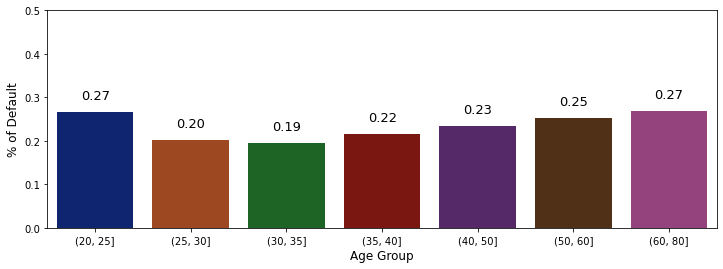

In [19]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "AgeBin", y = "Default", data = df, palette = 'dark', ci = None, order = AgeBin_order)

plt.xlabel("Age Group", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

As expected, the lowest chances of default are registered around 30-35 years old, while the highest occur at the extremes (20-25 and 60+).



## MARRIAGE

In [20]:
# (1=married, 2=single, 3=others)
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [21]:
df['Default'].groupby(df['MARRIAGE']).value_counts(normalize = True)


MARRIAGE  Default
1         0          0.765283
          1          0.234717
2         0          0.790717
          1          0.209283
3         0          0.763926
          1          0.236074
Name: Default, dtype: float64

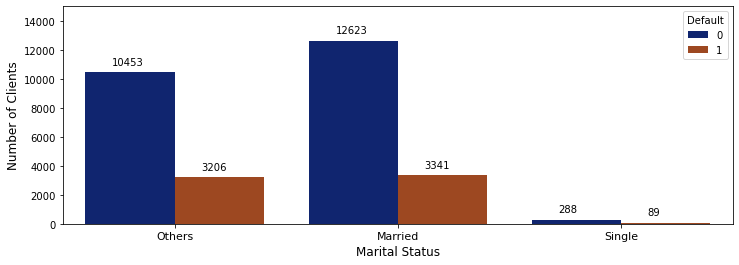

In [22]:

plt.figure(figsize=(12,4))

ax = sns.countplot(data = df, x = 'MARRIAGE', hue="Default", palette = 'dark')

plt.xlabel("Marital Status", fontsize= 12)
plt.ylabel("Number of Clients", fontsize= 12)
plt.ylim(0,15000)
plt.xticks([0,1,2],['Others', 'Married', 'Single'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.12, p.get_height()+500))
plt.show()

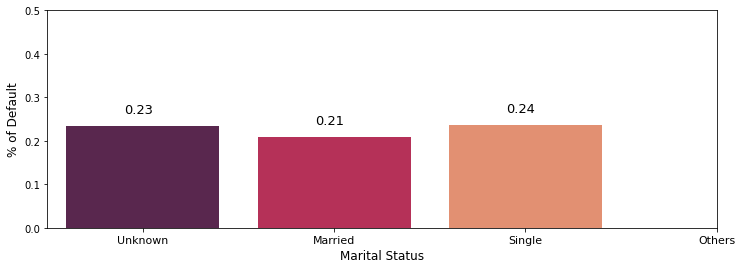

In [23]:

plt.figure(figsize=(12,4))

ax = sns.barplot(x = "MARRIAGE", y = "Default", data = df, palette = 'rocket', ci = None)
plt.xlabel("Marital Status", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Others'], fontsize = 11)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.30, p.get_height()+0.03),fontsize=13)

plt.show()

Analyse

## SEX

In [24]:
df.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

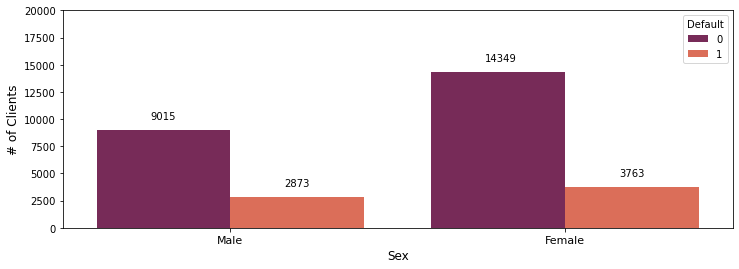

In [25]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = df, x = 'SEX', hue="Default", palette = 'rocket')

plt.xlabel("Sex", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,20000)
plt.xticks([0,1],['Male', 'Female'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.16, p.get_height()+1000))

plt.show()

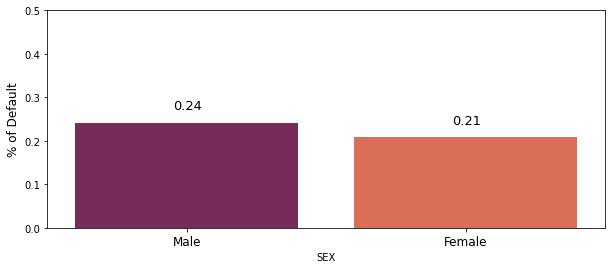

In [26]:
plt.figure(figsize=(10,4))

ax = sns.barplot(x = "SEX", y = "Default", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.35, p.get_height()+0.03),fontsize=13)

plt.show()

There are more women than men in our dataset and, apparently, men have a slightly higher chance of default. We will try to confirm it a little later by comparing men and women with the same education and marital status.



## EDUCATION

As we saw on the descriptive statistics (df.describe), there is a minimum value of 0 in 'Education', which didn't match the possible values for this feature according to the original dataset information. The additional information puts 4 values (0, 4, 5, 6) in the same category ('others').

The values '5' and '6' are both originally labelled as 'unknown' and we don't have a defined label for '0'. Maybe we can put them all together in the same category. But first, we will leave it as it is for now and check how many samples there are in each category and what is their percentage of Default.

In [27]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [28]:
df['Default'].groupby(df['EDUCATION']).value_counts(normalize = True)


EDUCATION  Default
1          0          0.807652
           1          0.192348
2          0          0.762651
           1          0.237349
3          0          0.748424
           1          0.251576
4          0          0.929487
           1          0.070513
Name: Default, dtype: float64

In [29]:
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(0,5)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(6,5)

In [30]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

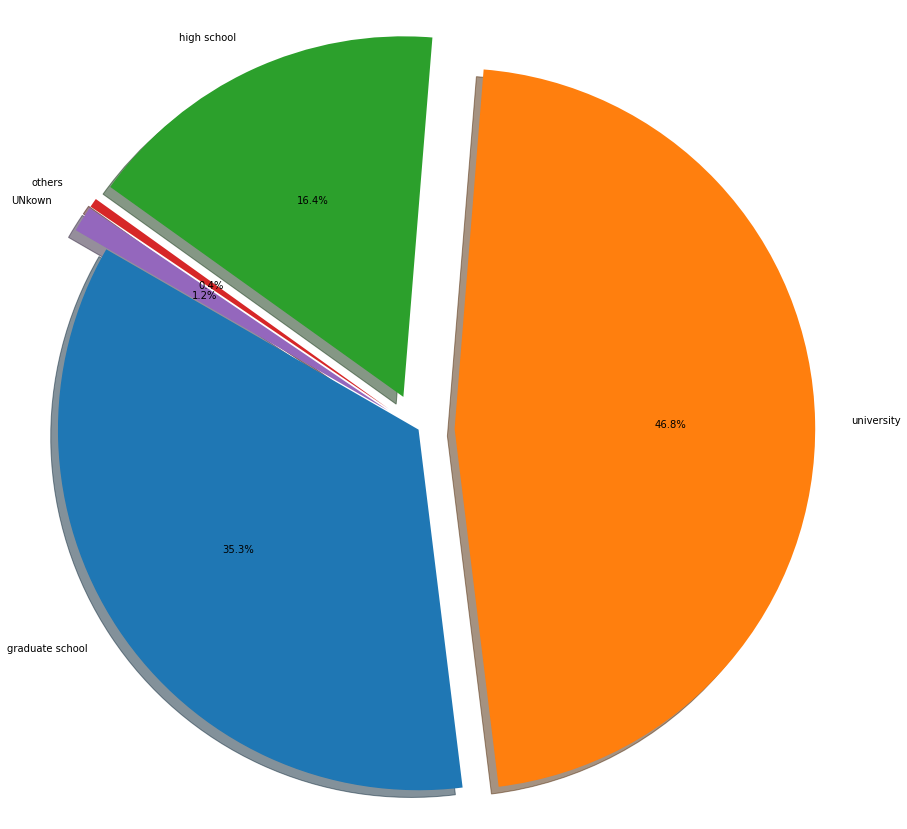

In [31]:
counts_left=[10585,14030,4917,123,345]
department_left=['graduate school','university','high school','others','UNkown']
explode=[0,0.1,0.1,0.1,0.1]
fig1, ax1 = plt.subplots(figsize=(15,15))
ax1.pie(counts_left, explode=explode,labels=department_left, autopct='%1.1f%%',
        shadow=True, startangle=150)
ax1.axis('equal')  
plt.show()

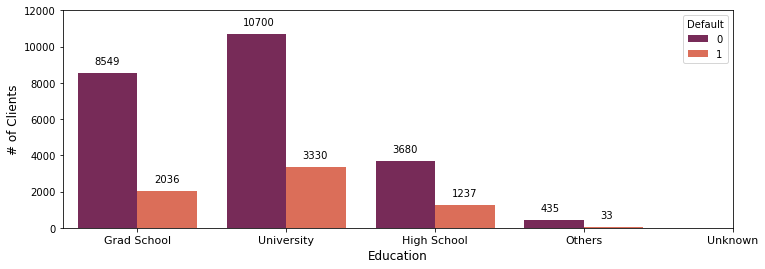

In [32]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = df, x = 'EDUCATION', hue="Default", palette = 'rocket')

plt.xlabel("Education", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,12000)
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.11, p.get_height()+500))

plt.show()

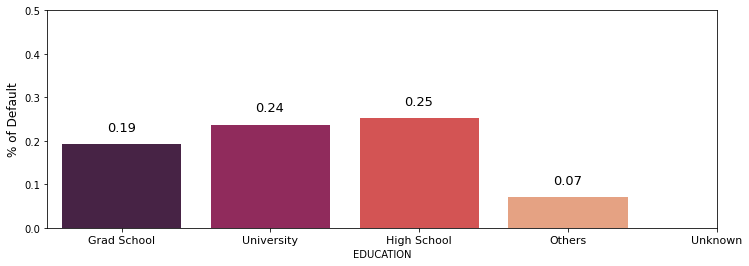

In [33]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "EDUCATION", y = "Default", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.30, p.get_height()+0.03),fontsize=13)

plt.show()

The predominant level of education in our dataset is 'University', followed by 'Grad School', 'High School', 'Unknown' and 'Others'.

Considering only the first three levels, it seems that a higher education translates to a lower chance of default. However, both 'Unknown' and 'Others' (which we would presume that it means a lower level than high school), have a noticeably lower probability.

## Sex + Education/Marital Status


In [34]:
df.groupby(by=['MARRIAGE', 'SEX'])['Default'].value_counts(normalize = True)


MARRIAGE  SEX  Default
1         1    0          0.740655
               1          0.259345
          2    0          0.780375
               1          0.219625
2         1    0          0.773386
               1          0.226614
          2    0          0.802784
               1          0.197216
3         1    0          0.710345
               1          0.289655
          2    0          0.797414
               1          0.202586
Name: Default, dtype: float64

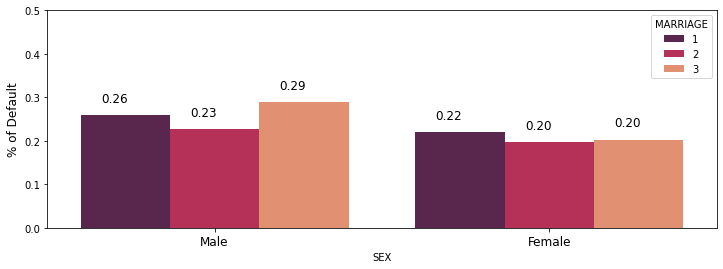

In [35]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "SEX", y = "Default", hue = "MARRIAGE", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.06, p.get_height()+0.03),fontsize=12)

plt.show()

In [36]:
df.groupby(by=['EDUCATION', 'SEX'])['Default'].value_counts(normalize = True)


EDUCATION  SEX  Default
1          1    0          0.791915
                1          0.208085
           2    0          0.818649
                1          0.181351
2          1    0          0.737998
                1          0.262002
           2    0          0.777957
                1          0.222043
3          1    0          0.726131
                1          0.273869
           2    0          0.763580
                1          0.236420
4          1    0          0.917647
                1          0.082353
           2    0          0.936242
                1          0.063758
Name: Default, dtype: float64

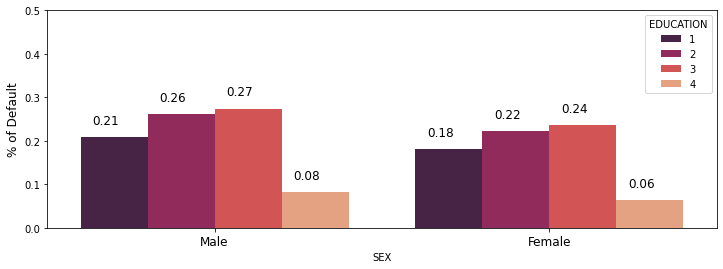

In [37]:

plt.figure(figsize=(12,4))

ax = sns.barplot(x = "SEX", y = "Default", hue = "EDUCATION", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.035, p.get_height()+0.03),fontsize=12)

plt.show()

In every single comparison, the probability of default was higher for men.



## Amount of Given Credit (LIMIT_BAL)


C:\Users\kais\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


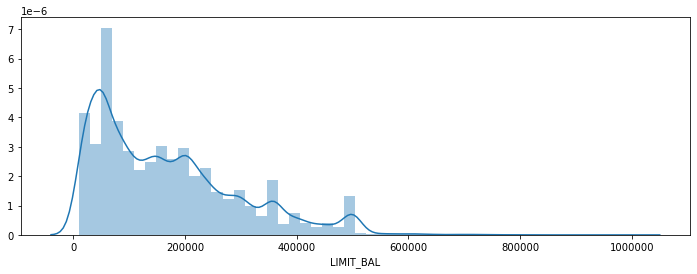

In [38]:
plt.figure(figsize=(12,4))

sns.distplot(df['LIMIT_BAL'])
plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation on x
plt.ylabel('')
plt.show()

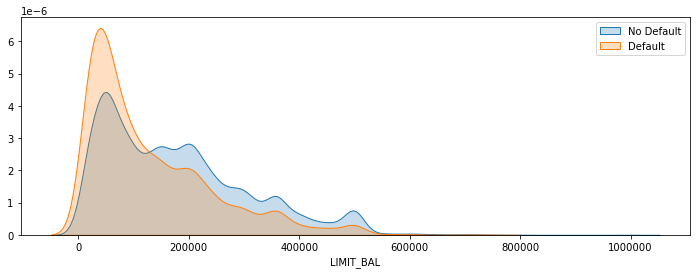

In [39]:
plt.figure(figsize=(12,4))

sns.kdeplot(df.loc[(df['Default'] == 0), 'LIMIT_BAL'], label = 'No Default', shade = True)
sns.kdeplot(df.loc[(df['Default'] == 1), 'LIMIT_BAL'], label = 'Default', shade = True)
plt.ticklabel_format(style='plain', axis='x') 
plt.ylabel('')
plt.legend()
plt.show()

In [40]:
df['LimitBin'] = pd.cut(df['LIMIT_BAL'],[5000, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1100000])
print(df['LimitBin'].value_counts())

(5000, 50000]        7676
(200000, 300000]     5059
(50000, 100000]      4822
(150000, 200000]     3978
(100000, 150000]     3902
(300000, 400000]     2759
(400000, 500000]     1598
(500000, 1100000]     206
Name: LimitBin, dtype: int64


In [41]:
df['Default'].groupby(df['LimitBin']).value_counts(normalize = True)

LimitBin           Default
(5000, 50000]      0          0.682126
                   1          0.317874
(50000, 100000]    0          0.742016
                   1          0.257984
(100000, 150000]   0          0.788570
                   1          0.211430
(150000, 200000]   0          0.821518
                   1          0.178482
(200000, 300000]   0          0.839494
                   1          0.160506
(300000, 400000]   0          0.859369
                   1          0.140631
(400000, 500000]   0          0.878598
                   1          0.121402
(500000, 1100000]  0          0.888350
                   1          0.111650
Name: Default, dtype: float64

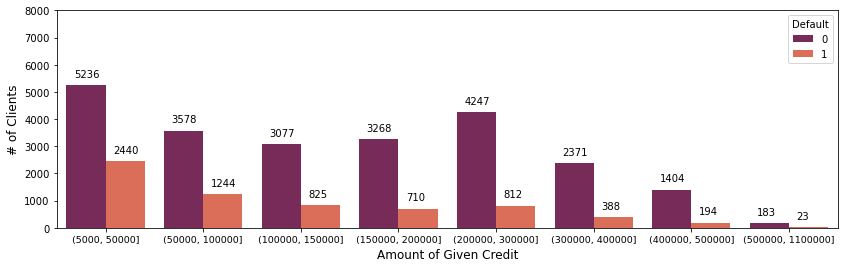

In [42]:
plt.figure(figsize=(14,4))

df['LimitBin'] = df['LimitBin'].astype('str')
LimitBin_order = ['(5000, 50000]', '(50000, 100000]', '(100000, 150000]', '(150000, 200000]',
                '(200000, 300000]', '(300000, 400000]', '(400000, 500000]', '(500000, 1100000]']

ax = sns.countplot(data = df, x = 'LimitBin', hue="Default", palette = 'rocket', order = LimitBin_order)

plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,8000)
ax.tick_params(axis="x", labelsize= 9.5)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.075, p.get_height()+300))

plt.show()

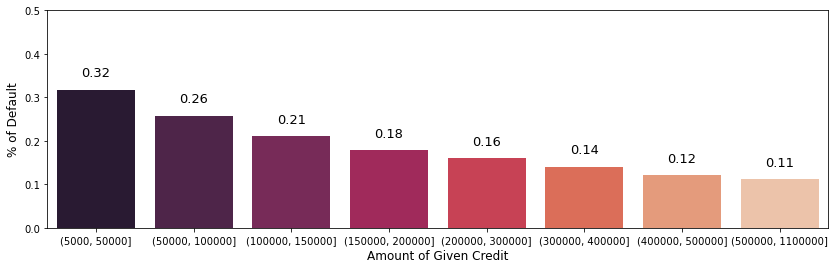

In [43]:
plt.figure(figsize=(14,4))

ax = sns.barplot(x = "LimitBin", y = "Default", data = df, palette = 'rocket', ci = None, order = LimitBin_order)

plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

Now it's pretty clear that there is a significant rate of default (over 30%) from customers with 50k or less of credit limit. We also can see that the higher the limit, the lower is the chance of defaulting.

## Amount of Given Credit (LIMIT_BAL) + Demographic Features

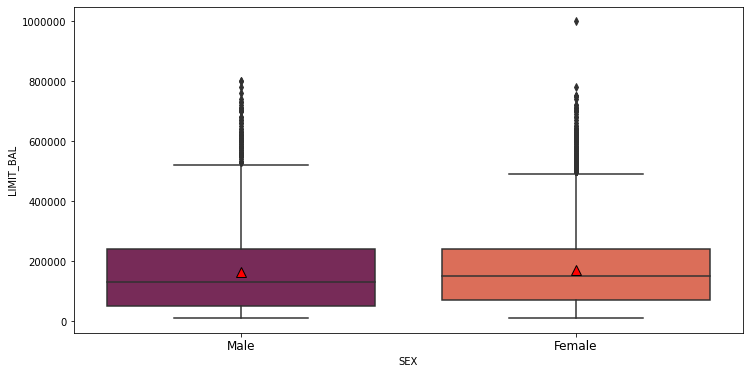

In [44]:
plt.figure(figsize=(12,6))

sns.boxplot(x = "SEX", y = "LIMIT_BAL",data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

plt.show()

In [45]:
df.groupby('EDUCATION')['LIMIT_BAL'].mean()

EDUCATION
1    212956.069910
2    147062.437634
3    126550.270490
4    181316.239316
Name: LIMIT_BAL, dtype: float64

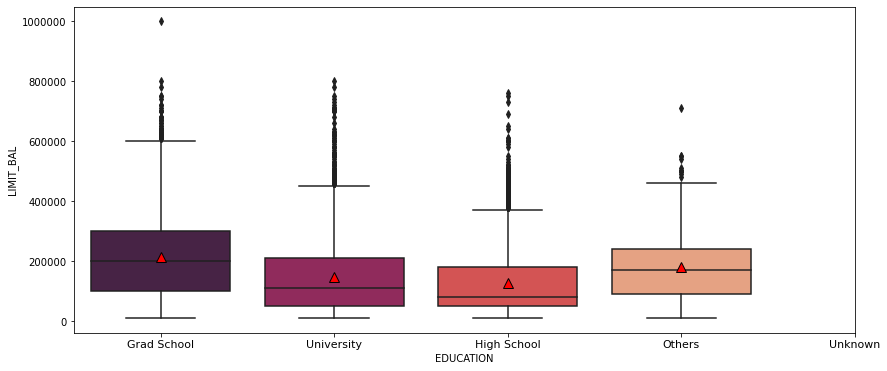

In [46]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL", data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation   
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

plt.show()

In [47]:
df.groupby('MARRIAGE')['LIMIT_BAL'].mean()


MARRIAGE
1    182200.893184
2    156413.660737
3    103076.923077
Name: LIMIT_BAL, dtype: float64

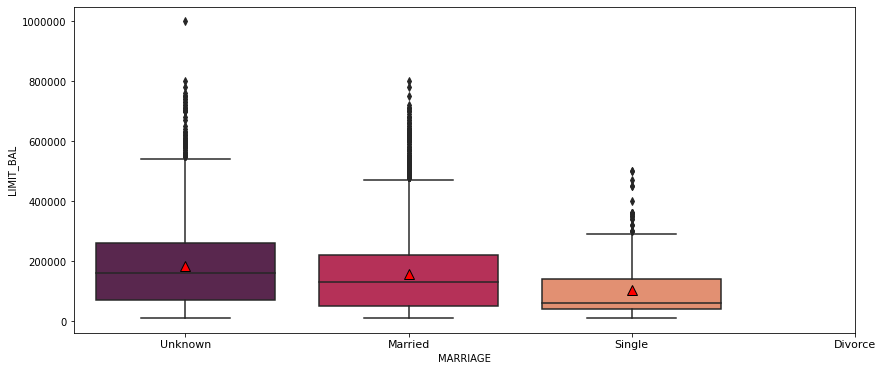

In [48]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.show()

In [49]:
df.groupby('AgeBin')['LIMIT_BAL'].mean()

AgeBin
(20, 25]     73763.885301
(25, 30]    164320.918510
(30, 35]    197688.060732
(35, 40]    196780.557250
(40, 50]    179680.213156
(50, 60]    159349.023535
(60, 80]    201617.647059
Name: LIMIT_BAL, dtype: float64

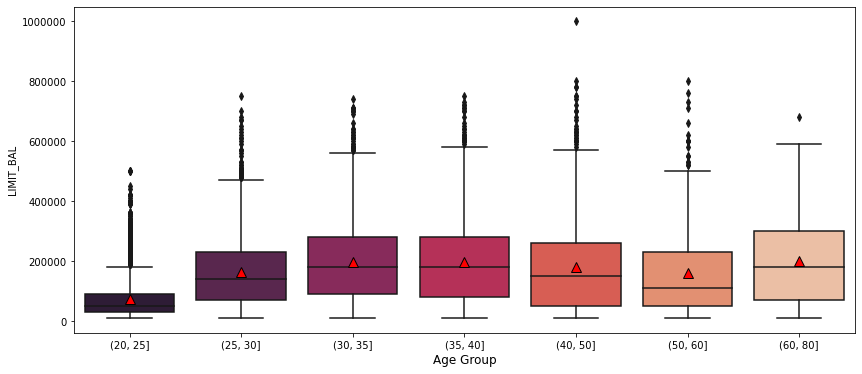

In [50]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL",data = df, palette = 'rocket', order = AgeBin_order, showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xlabel("Age Group", fontsize= 12)

plt.show()


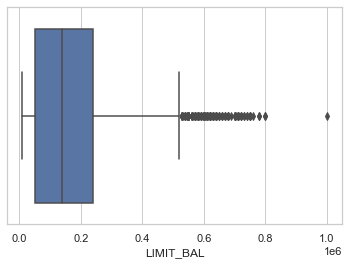

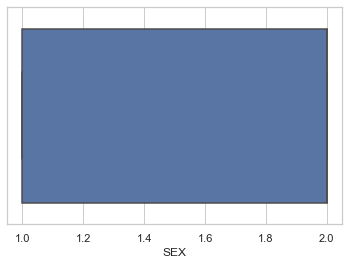

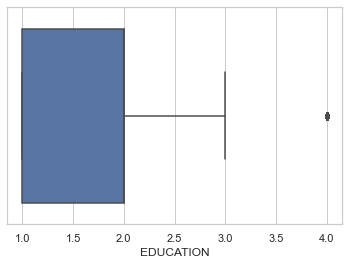

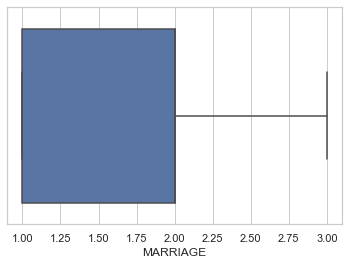

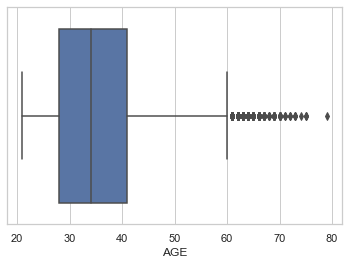

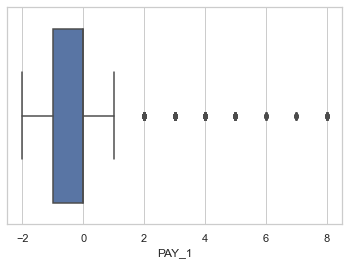

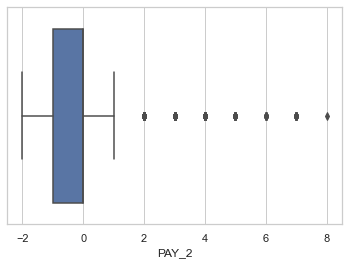

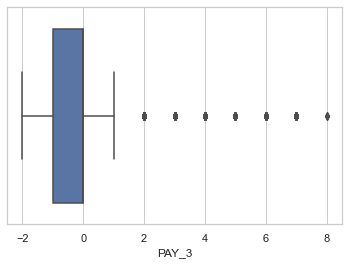

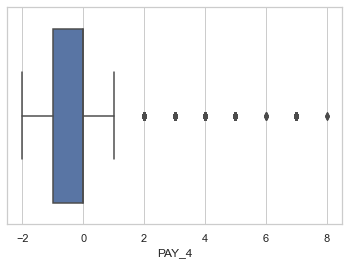

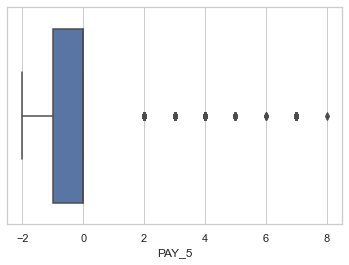

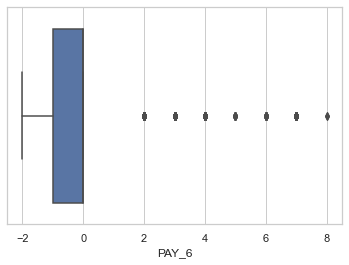

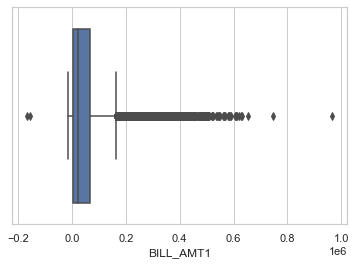

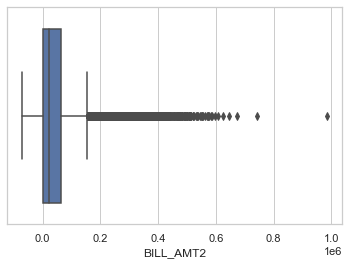

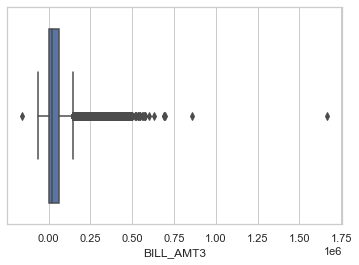

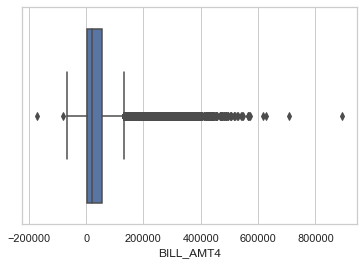

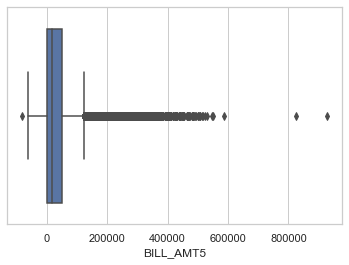

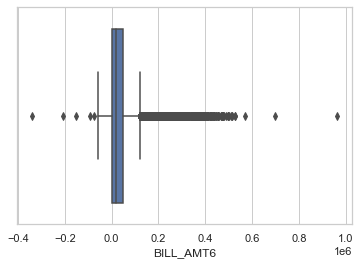

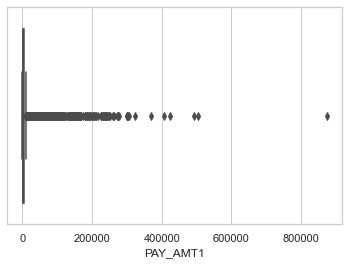

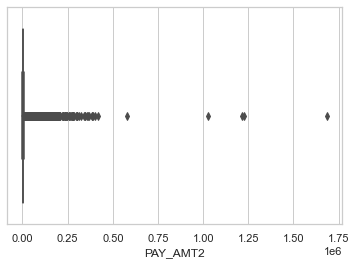

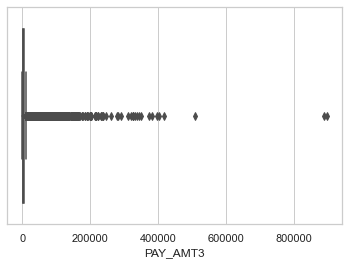

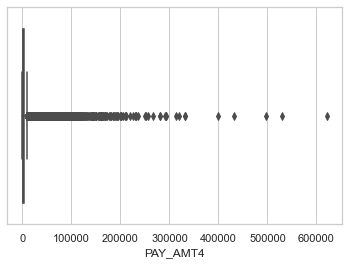

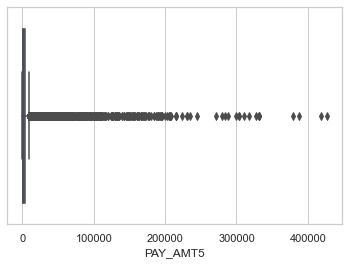

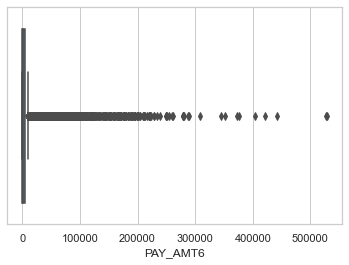

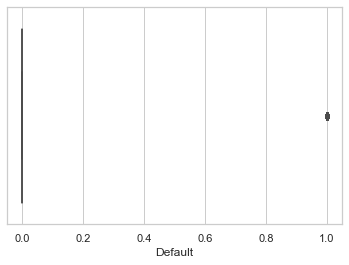

TypeError: Horizontal orientation requires numeric `x` variable.

In [51]:
import seaborn as sns
for i in range(len(df.columns)):
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=df[df.columns[i]])
    plt.show()

Overall, the offered credit limit seems to match the ability to pay in time within each category. The exceptions are the unknown categories, which have lower chances of default, but do not lead in the amount of given credit, and the age group of 60+, which, despite having one of the highest chances of default, receives, on average, the highest credit value.by age group.

We could analyze the relationship between the credit limit and the combination of two demographic features to see if we can find something different. In this notebook, I’ll only plot the ‘sex’ feature combined with the remaining demographic features.

In [ ]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation   
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

plt.show()

In [ ]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.show()

In [ ]:

plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', order = AgeBin_order, showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xlabel("Age Group", fontsize= 12)

plt.show()

We saw earlier that the average given credit for women was slightly higher than for men. That still holds up for several combinations of categories, except among customers that:

Have a grad school diploma;
Are married;
Are 50+ years old.

## Repayment Status (PAY_X)


In [ ]:
pay_x_fts = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_fts):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(df.loc[:,col], palette = 'rocket')
    plt.ylim(0,20000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.08, p.get_height()+500), fontsize = 11)

plt.show()

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_fts):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'rocket', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,1.2)
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.09, p.get_height()+0.03),fontsize=13)

plt.show()

Most customers are duly paying their credit card bills. And it's pretty clear that their likelihood of default are much lower than the rest.

Since there are only a few customers with 4+ months of delay in all PAY_X features, we could make a new analysis with them all together just to have the average default of a more significant group.

In [ ]:
df['PAY_1_new'] = df['PAY_1'].copy()
df['PAY_2_new'] = df['PAY_2'].copy()
df['PAY_3_new'] = df['PAY_3'].copy()
df['PAY_4_new'] = df['PAY_4'].copy()
df['PAY_5_new'] = df['PAY_5'].copy()
df['PAY_6_new'] = df['PAY_6'].copy()

In [ ]:
pay_x_new = ['PAY_1_new', 'PAY_2_new', 'PAY_3_new', 'PAY_4_new', 'PAY_5_new', 'PAY_6_new']

for col in pay_x_new:  
    df.loc[:,col] = df.loc[:,col].replace(5,4)
    df.loc[:,col] = df.loc[:,col].replace(6,4)
    df.loc[:,col] = df.loc[:,col].replace(7,4)
    df.loc[:,col] = df.loc[:,col].replace(8,4)

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_new):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, palette = 'rocket')
    plt.ylim(0,20000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.180, p.get_height()+700), fontsize = 11)

plt.show()

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_new):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'rocket', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,1.0)
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.20, p.get_height()+0.03),fontsize=13)

plt.show()

## Amount of Bill Statement (BILL_AMTX)

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(10,10))               # 'ax' has references to all the four axes
sns.distplot(df['BILL_AMT6'], ax = ax[0,0]) 
sns.distplot(df['BILL_AMT5'], ax = ax[0,1]) 
sns.distplot(df['BILL_AMT4'], ax = ax[0,2]) 
sns.distplot(df['BILL_AMT3'], ax = ax[1,0]) 
sns.distplot(df['BILL_AMT2'], ax = ax[1,1]) 
sns.distplot(df['BILL_AMT1'], ax = ax[1,2])
 
plt.show()

In [ ]:
plt.subplots(figsize=(20,20))

plt.subplot(231)
plt.scatter(x=df.PAY_AMT1, y=df.BILL_AMT1, c='r', s=1)

plt.subplot(232)
plt.scatter(x=df.PAY_AMT2, y=df.BILL_AMT2, c='b', s=1)

plt.subplot(233)
plt.scatter(x=df.PAY_AMT3, y=df.BILL_AMT3, c='g', s=1)

plt.subplot(234)
plt.scatter(x=df.PAY_AMT4, y=df.BILL_AMT4, c='c', s=1)
plt.ylabel("Bill Amount in past 6 months", fontsize=25)

plt.subplot(235)
plt.scatter(x=df.PAY_AMT5, y=df.BILL_AMT5, c='y', s=1)
plt.xlabel("Payment in past 6 months", fontsize=25)

plt.subplot(236)
plt.scatter(x=df.PAY_AMT6, y=df.BILL_AMT6, c='m', s=1)

plt.show()

In [ ]:

bill_amtx_fts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_fts):    
    plt.subplot(3,2,i + 1)    
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label = 'No Default', shade = True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label = 'Default', shade = True)
    plt.xlim(-50000,200000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()

In [ ]:
df['BILL_AMT1_bin'] = df['BILL_AMT1'].copy()
df['BILL_AMT2_bin'] = df['BILL_AMT2'].copy()
df['BILL_AMT3_bin'] = df['BILL_AMT3'].copy()
df['BILL_AMT4_bin'] = df['BILL_AMT4'].copy()
df['BILL_AMT5_bin'] = df['BILL_AMT5'].copy()
df['BILL_AMT6_bin'] = df['BILL_AMT6'].copy()

In [ ]:
bill_amtx_bins = ['BILL_AMT1_bin', 'BILL_AMT2_bin', 'BILL_AMT3_bin', 'BILL_AMT4_bin', 'BILL_AMT5_bin', 'BILL_AMT6_bin']

for i, col in enumerate (bill_amtx_bins):
    df[col] = pd.cut(df[bill_amtx_fts[i]],[-350000,-1,0,25000, 75000, 200000, 2000000])
    print(df[col].value_counts())

In [ ]:
for col in bill_amtx_bins:
    print(df['Default'].groupby(df[col]).value_counts(normalize = True))

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, hue="Default", palette = 'rocket')
    plt.ylim(0,13000)
    plt.ylabel('')
    plt.xticks([0,1,2,3,4,5],['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize = 11)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()+700), fontsize = 11)    
        
plt.show()

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'rocket', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.xticks([0,1,2,3,4,5],['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize = 11)    
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.21, p.get_height()+0.03),fontsize=13)

plt.show()

As expected, those who have a negative bill statement have a lower chance of default than the rest. What stands out is that there is a little higher chance of default for those who didn't have a bill in the previous months.

## Amount of Previous Payment (PAY_AMTX)

In [ ]:
pay_amtx_fts = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_fts):    
    plt.subplot(3,2,i + 1)
    sns.distplot(df.loc[:,col])
    plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation
    plt.ylabel('')
    plt.tight_layout()

plt.show()

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_fts):    
    plt.subplot(3,2,i + 1)    
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label = 'No Default', shade = True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label = 'Default', shade = True)
    plt.xlim(0,100000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()

In [ ]:
df['PAY_AMT1_bin'] = df['PAY_AMT1'].copy()
df['PAY_AMT2_bin'] = df['PAY_AMT2'].copy()
df['PAY_AMT3_bin'] = df['PAY_AMT3'].copy()
df['PAY_AMT4_bin'] = df['PAY_AMT4'].copy()
df['PAY_AMT5_bin'] = df['PAY_AMT5'].copy()
df['PAY_AMT6_bin'] = df['PAY_AMT6'].copy()

In [ ]:
pay_amtx_bins = ['PAY_AMT1_bin', 'PAY_AMT2_bin', 'PAY_AMT3_bin', 'PAY_AMT4_bin', 'PAY_AMT5_bin', 'PAY_AMT6_bin']

for i, col in enumerate (pay_amtx_bins):
    df[col] = pd.cut(df[pay_amtx_fts[i]],[-1, 0, 25000, 50000, 100000, 2000000])
    print(df[col].value_counts())

In [ ]:
for col in pay_amtx_bins:
    print(df['Default'].groupby(df[col]).value_counts(normalize = True))

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, hue="Default", palette = 'rocket')
    plt.ylim(0,23000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+800), fontsize=11)    

plt.show()

In [ ]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'rocket', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.tight_layout()

In [ ]:
df.info()

In [ ]:
df.

# DATA PREPROCESSING

In [57]:
df=df[df.MARRIAGE >0]

In [58]:
df=df[df.EDUCATION <5]

In [59]:
df.shape

(30000, 26)

In [60]:
X_base = df.copy().drop(pay_x_new, axis = 1)
X_base = X_base.drop(bill_amtx_bins, axis = 1)
X_base = X_base.drop(pay_amtx_bins, axis = 1)
X_base = X_base.drop(['AgeBin', 'LimitBin'], axis = 1)
X_base.head()

NameError: name 'pay_x_new' is not defined

In [ ]:
X_base.shape

### SPLIT DATA

In [ ]:
X_base_train, X_base_test, Y_train, Y_test = train_test_split(X_base, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

## RANDOM FOREST

In [53]:
rf_model = RandomForestClassifier(random_state = 42)

rf_model.fit(X_base_train, Y_train)
pred_rf = rf_model.predict(X_base_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf))

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
rf_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_rf, labels = [0, 1]))

In [52]:
rf_pred_proba = rf_model.predict_proba(X_base_test)[:,1]

rf_roc_auc = metrics.roc_auc_score(Y_test, rf_pred_proba)
print('ROC_AUC: ', rf_roc_auc)

rf_fpr, rf_tpr, thresholds = metrics.roc_curve(Y_test, rf_pred_proba)

plt.plot(rf_fpr,rf_tpr, label = 'ROC_AUC = %0.3f' % rf_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

NameError: name 'rf_model' is not defined

### CATBOOST

In [56]:
categorical_ft_base = ['SEX', 'EDUCATION', 'MARRIAGE']

cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model.fit(X_base_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_base_test,Y_test)], cat_features = categorical_ft_base)
pred_cat = cat_model.predict(X_base_test)

NameError: name 'X_base_train' is not defined

In [ ]:
print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))

In [ ]:

cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

In [ ]:
cat_pred_proba = cat_model.predict_proba(X_base_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

## Catboost (with Added Features

In [ ]:
X_new = X.copy().drop(pay_x_new, axis = 1)
X_new = X_new.drop(bill_amtx_bins, axis = 1)
X_new = X_new.drop(['AgeBin', 'LimitBin'], axis = 1)

X_new

In [ ]:
X_new.info()

In [ ]:
le = LabelEncoder()

for col in pay_amtx_bins:
    X_new[col] = le.fit_transform(X_new[col])

In [ ]:
X_new_train, X_new_test, Y_train, Y_test = train_test_split(X_new, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

In [ ]:
categorical_ft_new = ['SEX', 'EDUCATION', 'MARRIAGE'
                      , 'PAY_AMT1_bin', 'PAY_AMT2_bin', 'PAY_AMT3_bin', 'PAY_AMT4_bin', 'PAY_AMT5_bin', 'PAY_AMT6_bin']

print(categorical_ft_new)

cat_model_new = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model_new.fit(X_new_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_new_test,Y_test)], cat_features = categorical_ft_new)
pred_cat_new = cat_model_new.predict(X_new_test)

In [ ]:
print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat_new))

In [ ]:
cat_new_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat_new)
sns.heatmap(cat_new_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_cat_new, labels = [0, 1]))

In [ ]:
cat_new_pred_proba = cat_model_new.predict_proba(X_new_test)[:,1]

cat_new_roc_auc = metrics.roc_auc_score(Y_test, cat_new_pred_proba)
print('ROC_AUC: ', cat_new_roc_auc)

cat_new_fpr, cat_new_tpr, thresholds = metrics.roc_curve(Y_test, cat_new_pred_proba)

plt.plot(cat_new_fpr,cat_new_tpr, label = 'ROC_AUC = %0.3f' % cat_new_roc_auc)
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [ ]:
pool = Pool(X_new_train, Y_train, cat_features=categorical_ft_new)

Feature_importance = pd.DataFrame({'feature_importance': cat_model_new.get_feature_importance(pool), 
                      'feature_names': X_new_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Feature_importance

In [ ]:
plt.figure(figsize=(10,10))

sns.barplot(x=Feature_importance['feature_importance'], y=Feature_importance['feature_names'], palette = 'rocket')

plt.show()

##  XGBOOST

In [ ]:
turnover = xgb.DMatrix(data=X_base,label=Y)

gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
'n_estimators': [200],
'subsample': [0.3, 0.5, 0.9],"max_depth":[2,3,4,5],'colsample_bytree':[0.1,0.3,.0,8,0.9,0.15]}

gbm = xgb.XGBClassifier()
grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,
scoring='accuracy', cv=4, verbose=1)
grid_mse.fit(X_base, Y)
print("Best parameters found: ",grid_mse.best_params_)
print("best accuracy found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [ ]:
reg_xgb = xgb.XGBClassifier(colsample_bytree= 0.9, learning_rate= 0.01, max_depth=4, n_estimators=200, subsample= 0.3)
reg_xgb.fit(X_base_train, Y_train)

pred_xgb = reg_xgb.predict(X_base_test)
print('xgb_accuracy: {:.3f}'.format(metrics.accuracy_score(Y_test, pred_xgb)))

In [ ]:
xgb.plot_importance(reg_xgb)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
X=df[['PAY_1','LIMIT_BAL','BILL_AMT1','PAY_AMT6','PAY_AMT2','PAY_AMT1','AGE','PAY_AMT3','PAY_AMT5','PAY_AMT4','BILL_AMT6','PAY_3','PAY_6']]
Y=df['Default']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

In [ ]:
reg_xgb = xgb.XGBClassifier(colsample_bytree= 0.9, learning_rate= 0.01, max_depth=4, n_estimators=200, subsample= 0.3)
reg_xgb.fit(X_train, Y_train)

pred_xgb = reg_xgb.predict(X_test)
print('xgb_accuracy: {:.3f}'.format(metrics.accuracy_score(Y_test, pred_xgb)))